### Importation of the different libraries

In [13]:
import numpy as np
from numpy.random import seed

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from keras import regularizers
from keras.models import load_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform

### Open the files cretaed in the feature_generation.py file

In [ ]:
atom_features = pd.read_csv('atom_features_PCA.csv', sep=",")

bond_features = pd.read_csv('bond_features_PCA.csv', sep=",")

smilesF = pd.read_csv('SMILES_200Features.csv')

### Normalization of the 200 Descriptors feature

In [14]:
sheader = []

smilesF = smilesF.fillna(0)

sheader = list(smilesF.columns.values)
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(smilesF)
scaled_df = pd.DataFrame(scaled, columns = sheader)

### Second ACP on the reunion of the Atomic & Bond Matrix

In [15]:
atom_features = atom_features.add_prefix('A_')

bond_features = bond_features.add_prefix('B_')

for i in range(0,12):
  i = str(i)
  column = 'B_'+i
  b1 = bond_features[column]
  
  name = column
  i = int(i)
  atom_features.insert(i,name,b1)

header_smilesf = []
header_smilesf = list(smilesF.columns.values)

#tf.random.set_seed(s)
#seed(s)
second_pca = PCA(n_components = 50) 
data_atom_pca = second_pca.fit_transform(atom_features)

pcaNames = []
for p in range(1,51):
  pc = str(p)
  pca = 'PCA'+pc
  pcaNames.append(pca)


data_atom_pca = pd.DataFrame(data=data_atom_pca, columns=pcaNames)

j = 0
for col in pcaNames:
  col_data = data_atom_pca[col]
  scaled_df.insert(j, col, col_data)
  j = j+1

data_atom_pca.shape

(100, 50)

### Creation of the final feature Matrix (which will be used for the trianing of the different models in the following)

In [16]:
final_df = data_atom_pca.merge(scaled_df)
features = final_df.to_numpy()

In [17]:
features.shape

(100, 258)

### Filtering the feature matrix by delating the 0-variance feature

In [18]:
sel = VarianceThreshold(0)
cleaned = sel.fit_transform(features)
cleaned.shape

(100, 224)

### Choose the best number of clusters (K)

In [25]:
pred = cleaned
km_scores = []
vae32 = []
db_score = []
for i in range(5, 50, 2):
  km = KMeans(n_clusters=i, random_state=25).fit(pred)
  km_preds = km.predict(pred)

  silhouette = silhouette_score(pred, km_preds, random_state=25)
  vae32.append(silhouette)
  #print("Silhouette score for number of cluster(s) {}: {}".format(i, silhouette))

plt.figure(figsize=(250, 80))
plt.title("", fontsize=96)
plt.scatter(x=[i for i in range(5, 50, 2)], y=vae32, s=6000, edgecolor='k', color='blue')
plt.grid(True, linewidth=10)
plt.xlabel("\nNumber of clusters", fontsize=180)
plt.ylabel("Silhouette score\n", fontsize=180)
plt.xticks([i for i in range(5, 50, 2)], fontsize=150)
plt.yticks(fontsize=150)
plt.show()

/Users/mjolif/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mjolif/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mjolif/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mjolif/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mjolif/an

### VAE & K-Means model&train

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
data_set = np.float32(cleaned)
trainloader = DataLoader(dataset=data_set, batch_size=1024)


class Autoencoder(nn.Module):
  def __init__(self, D_in, H=50, H2=12, latent_dim=32):

    # Encoder
    super(Autoencoder, self).__init__()
    self.linear1 = nn.Linear(D_in, H)
    self.lin_bn1 = nn.BatchNorm1d(num_features=H)
    self.linear2 = nn.Linear(H, H2)
    self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
    self.linear3 = nn.Linear(H2, H2)
    self.lin_bn3 = nn.BatchNorm1d(num_features=H2)

    #         # Latent vectors mu and sigma
    self.fc1 = nn.Linear(H2, latent_dim)
    self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
    self.fc21 = nn.Linear(latent_dim, latent_dim)
    self.fc22 = nn.Linear(latent_dim, latent_dim)

    #         # Sampling vector
    self.fc3 = nn.Linear(latent_dim, latent_dim)
    self.fc_bn3 = nn.BatchNorm1d(latent_dim)
    self.fc4 = nn.Linear(latent_dim, H2)
    self.fc_bn4 = nn.BatchNorm1d(H2)

    #         # Decoder
    self.linear4 = nn.Linear(H2, H2)
    self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
    self.linear5 = nn.Linear(H2, H)
    self.lin_bn5 = nn.BatchNorm1d(num_features=H)
    self.linear6 = nn.Linear(H, D_in)
    self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)

    self.relu = nn.ReLU()

  def encode(self, x):
    lin1 = self.relu(self.lin_bn1(self.linear1(x)))
    lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
    lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

    fc1 = F.relu(self.bn1(self.fc1(lin3)))

    r1 = self.fc21(fc1)
    r2 = self.fc22(fc1)

    return r1, r2

  def reparameterize(self, mu, logvar):
    if self.training:
      std = logvar.mul(0.5).exp_()
      eps = Variable(std.data.new(std.size()).normal_())
      return eps.mul(std).add_(mu)
    else:
      return mu

  def decode(self, z):
    fc3 = self.relu(self.fc_bn3(self.fc3(z)))
    fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

    lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
    lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
    return self.lin_bn6(self.linear6(lin5))

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)

    return self.decode(z), mu, logvar


###################################################################
class customLoss(nn.Module):
  def __init__(self):
    super(customLoss, self).__init__()
    self.mse_loss = nn.MSELoss(reduction="sum")

  #
  def forward(self, x_recon, x, mu, logvar):
    loss_MSE = self.mse_loss(x_recon, x)
    loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return loss_MSE + loss_KLD


######################################################################
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
  classname = m.__class__.__name__
  # for every Linear layer in a model..
  if classname.find('Linear') != -1:
    # get the number of the inputs
    n = m.in_features
    y = 1.0 / np.sqrt(n)
    m.weight.data.uniform_(-y, y)
    m.bias.data.fill_(0)


########################################################################
D_in = 224
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
model.apply(weights_init_uniform_rule)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = customLoss()

#########################################################################
# Training
epochs = 1000
log_interval = 50
val_losses = []
train_losses = []


def train(epoch):
  model.train()
  train_loss = 0
  for batch_idx, data in enumerate(trainloader):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    loss = loss_mse(recon_batch, data, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  #        if batch_idx % log_interval == 0:
  #            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
  #                epoch, batch_idx * len(data), len(trainloader.dataset),
  #                       100. * batch_idx / len(trainloader),
  #                       loss.item() / len(data)))
  if epoch % 200 == 0:
    print('====> Epoch: {} Average loss: {:.4f}'.format(
      epoch, train_loss / len(trainloader.dataset)))
    train_losses.append(train_loss / len(trainloader.dataset))


for epoch in range(1, epochs + 1):
  train(epoch)

###########################################################################
mu_output = []
logvar_output = []

with torch.no_grad():
  for i, (data) in enumerate(trainloader):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)

    mu_tensor = mu
    mu_output.append(mu_tensor)
    mu_result = torch.cat(mu_output, dim=0)

    logvar_tensor = logvar
    logvar_output.append(logvar_tensor)
    logvar_result = torch.cat(logvar_output, dim=0)
##################################################################################

pred = mu_result.cpu().detach().numpy()
pred.shape
np.save('pred_vae32_1500_epochs.npy', pred)

####################################################################################

====> Epoch: 200 Average loss: 170.7861
====> Epoch: 400 Average loss: 116.1816
====> Epoch: 600 Average loss: 89.6426
====> Epoch: 800 Average loss: 75.0385
====> Epoch: 1000 Average loss: 62.5702


### AE & K-Means_model&train

In [8]:
tf.random.set_seed(54)
x_train, x_test = train_test_split(cleaned, test_size=0.3, random_state=1)


x_train = np.array(x_train)
x_test = np.array(x_test)

# Set random seed
tf.random.set_seed(54)

# Encoder
inputs = tfkl.Input(shape = (224))
x = inputs
#x = tfkl.Dense(512,'relu')(x)
#x = tfkl.Dense(64,'relu')(x)
#x = tfkl.Dense(32,'relu')(x)
x = tfkl.Dense(16,'relu')(x)
encoder = tfk.Model(inputs = inputs, outputs = x)

# Decoder
inputs = tfkl.Input(shape = (16))
x = inputs
#x = tfkl.Dense(32,'relu')(x)
#x = tfkl.Dense(128,'relu')(x)
#x = tfkl.Dense(512,'relu')(x)
x = tfkl.Dense(224*1,'relu')(x)
decoder = tfk.Model(inputs = inputs, outputs = x)

# Autoencoder
inputs = tfkl.Input(shape = (224))
x = encoder(inputs)
x = decoder(x)
model = tfk.Model(inputs = inputs, outputs = x)

# Train the Autoencoder
model.compile(loss = 'mse',optimizer = 'adam')
model.fit(x_train, x_train,epochs = 10,batch_size = 32)



latent = encoder.predict(cleaned)

encoder.save('pca50_encoder32_10epoch.h5')

Epoch 1/10
3/3 [==============================] - 1s 6ms/step - loss: 0.8946
Epoch 2/10
3/3 [==============================] - 0s 6ms/step - loss: 0.8791
Epoch 3/10
3/3 [==============================] - 0s 4ms/step - loss: 0.8673
Epoch 4/10
3/3 [==============================] - 0s 5ms/step - loss: 0.8581
Epoch 5/10
3/3 [==============================] - 0s 4ms/step - loss: 0.8512
Epoch 6/10
3/3 [==============================] - 0s 8ms/step - loss: 0.8446
Epoch 7/10
3/3 [==============================] - 0s 11ms/step - loss: 0.8389
Epoch 8/10
3/3 [==============================] - 0s 8ms/step - loss: 0.8342
Epoch 9/10
3/3 [==============================] - 0s 6ms/step - loss: 0.8292
Epoch 10/10
4/4 [==============================] - 0s 2ms/step


/Users/mjolif/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### BIRCH train 

In [9]:
brc = Birch(threshold=0.5, branching_factor=50, n_clusters=30, compute_labels=True, copy=True)
brc.fit(cleaned)
labels = brc.labels_

### BIRCH Evaluation

In [10]:
loaded_array = cleaned

##K-Means & Internal clustering evaluations
kmeans = KMeans(50,random_state=21)
kmeans.fit(loaded_array)
labels = kmeans.labels_



ch = metrics.calinski_harabasz_score(cleaned, labels)
print('ch Score: %.3f' % ch)

ss = silhouette_score(cleaned, labels, metric='euclidean')
print('Silhouetter Score: %.3f' % ss)

DB = davies_bouldin_score(cleaned, labels)
print('DB Score: %.3f' % DB)

/Users/mjolif/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ch Score: 4.390
Silhouetter Score: 0.076
DB Score: 0.886


### Visualize Results

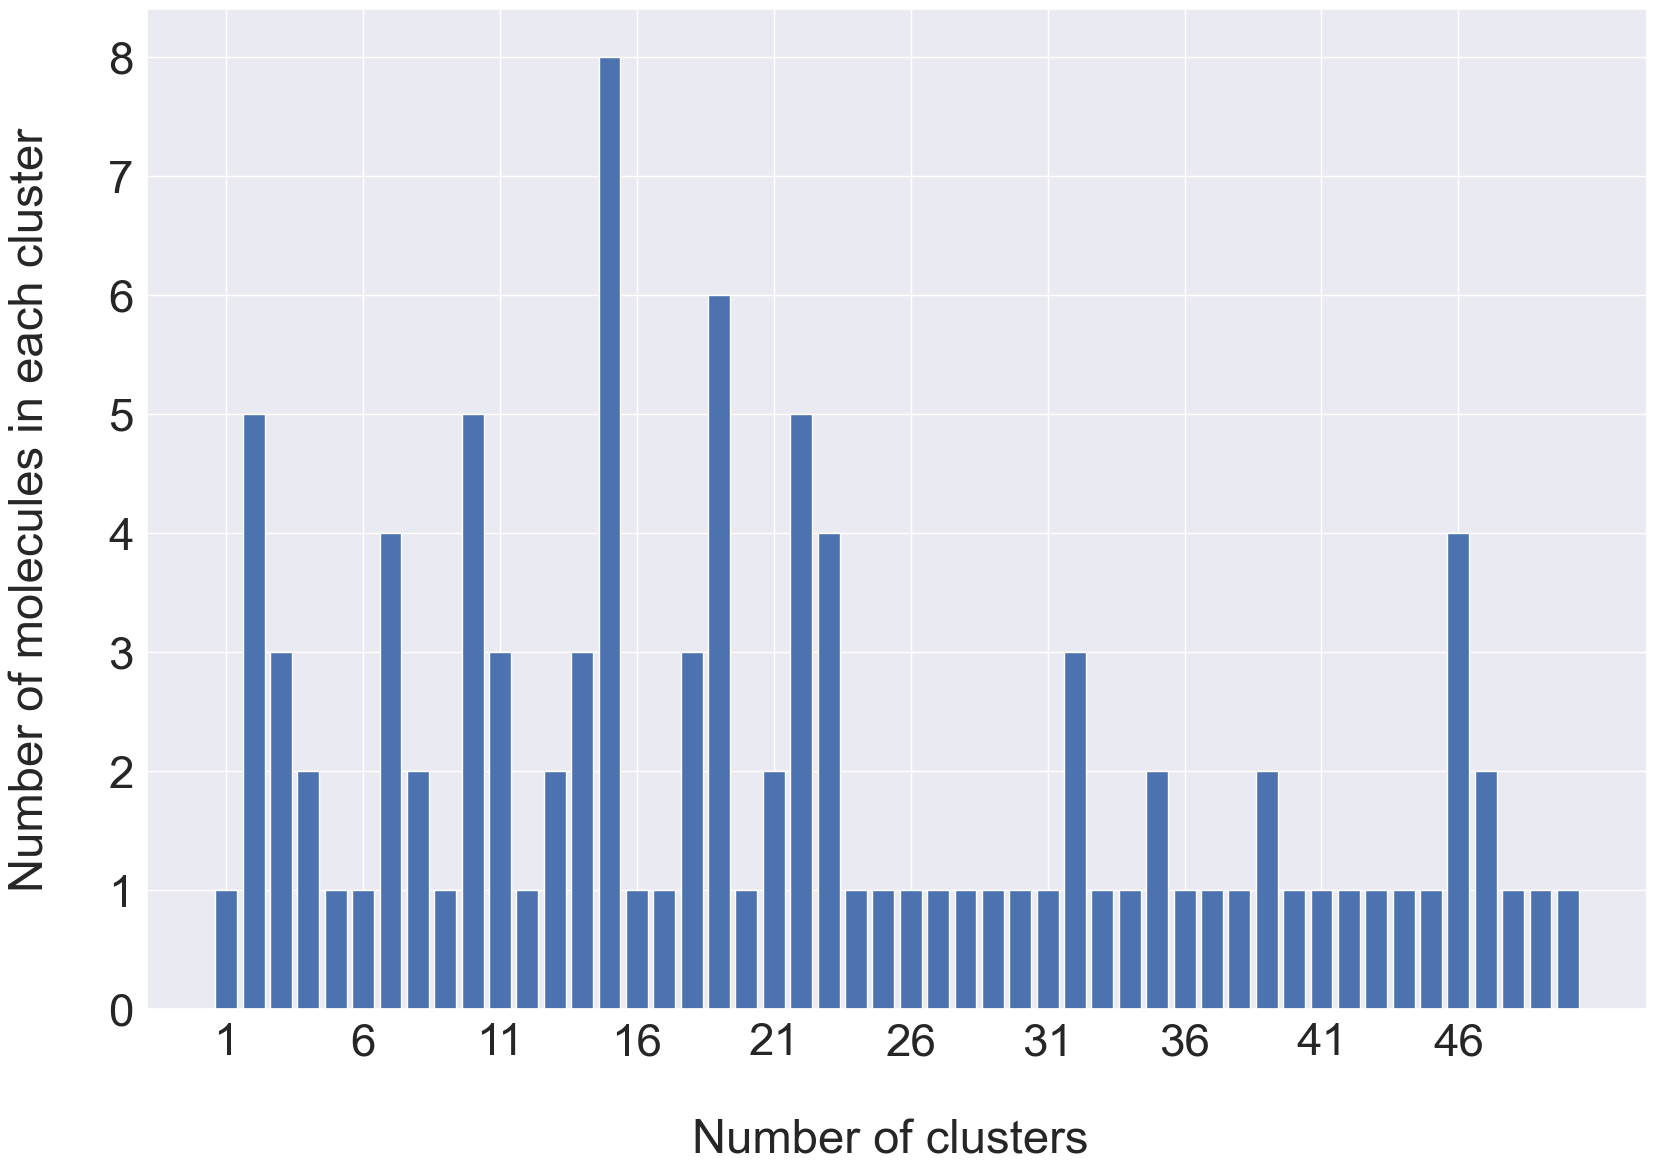

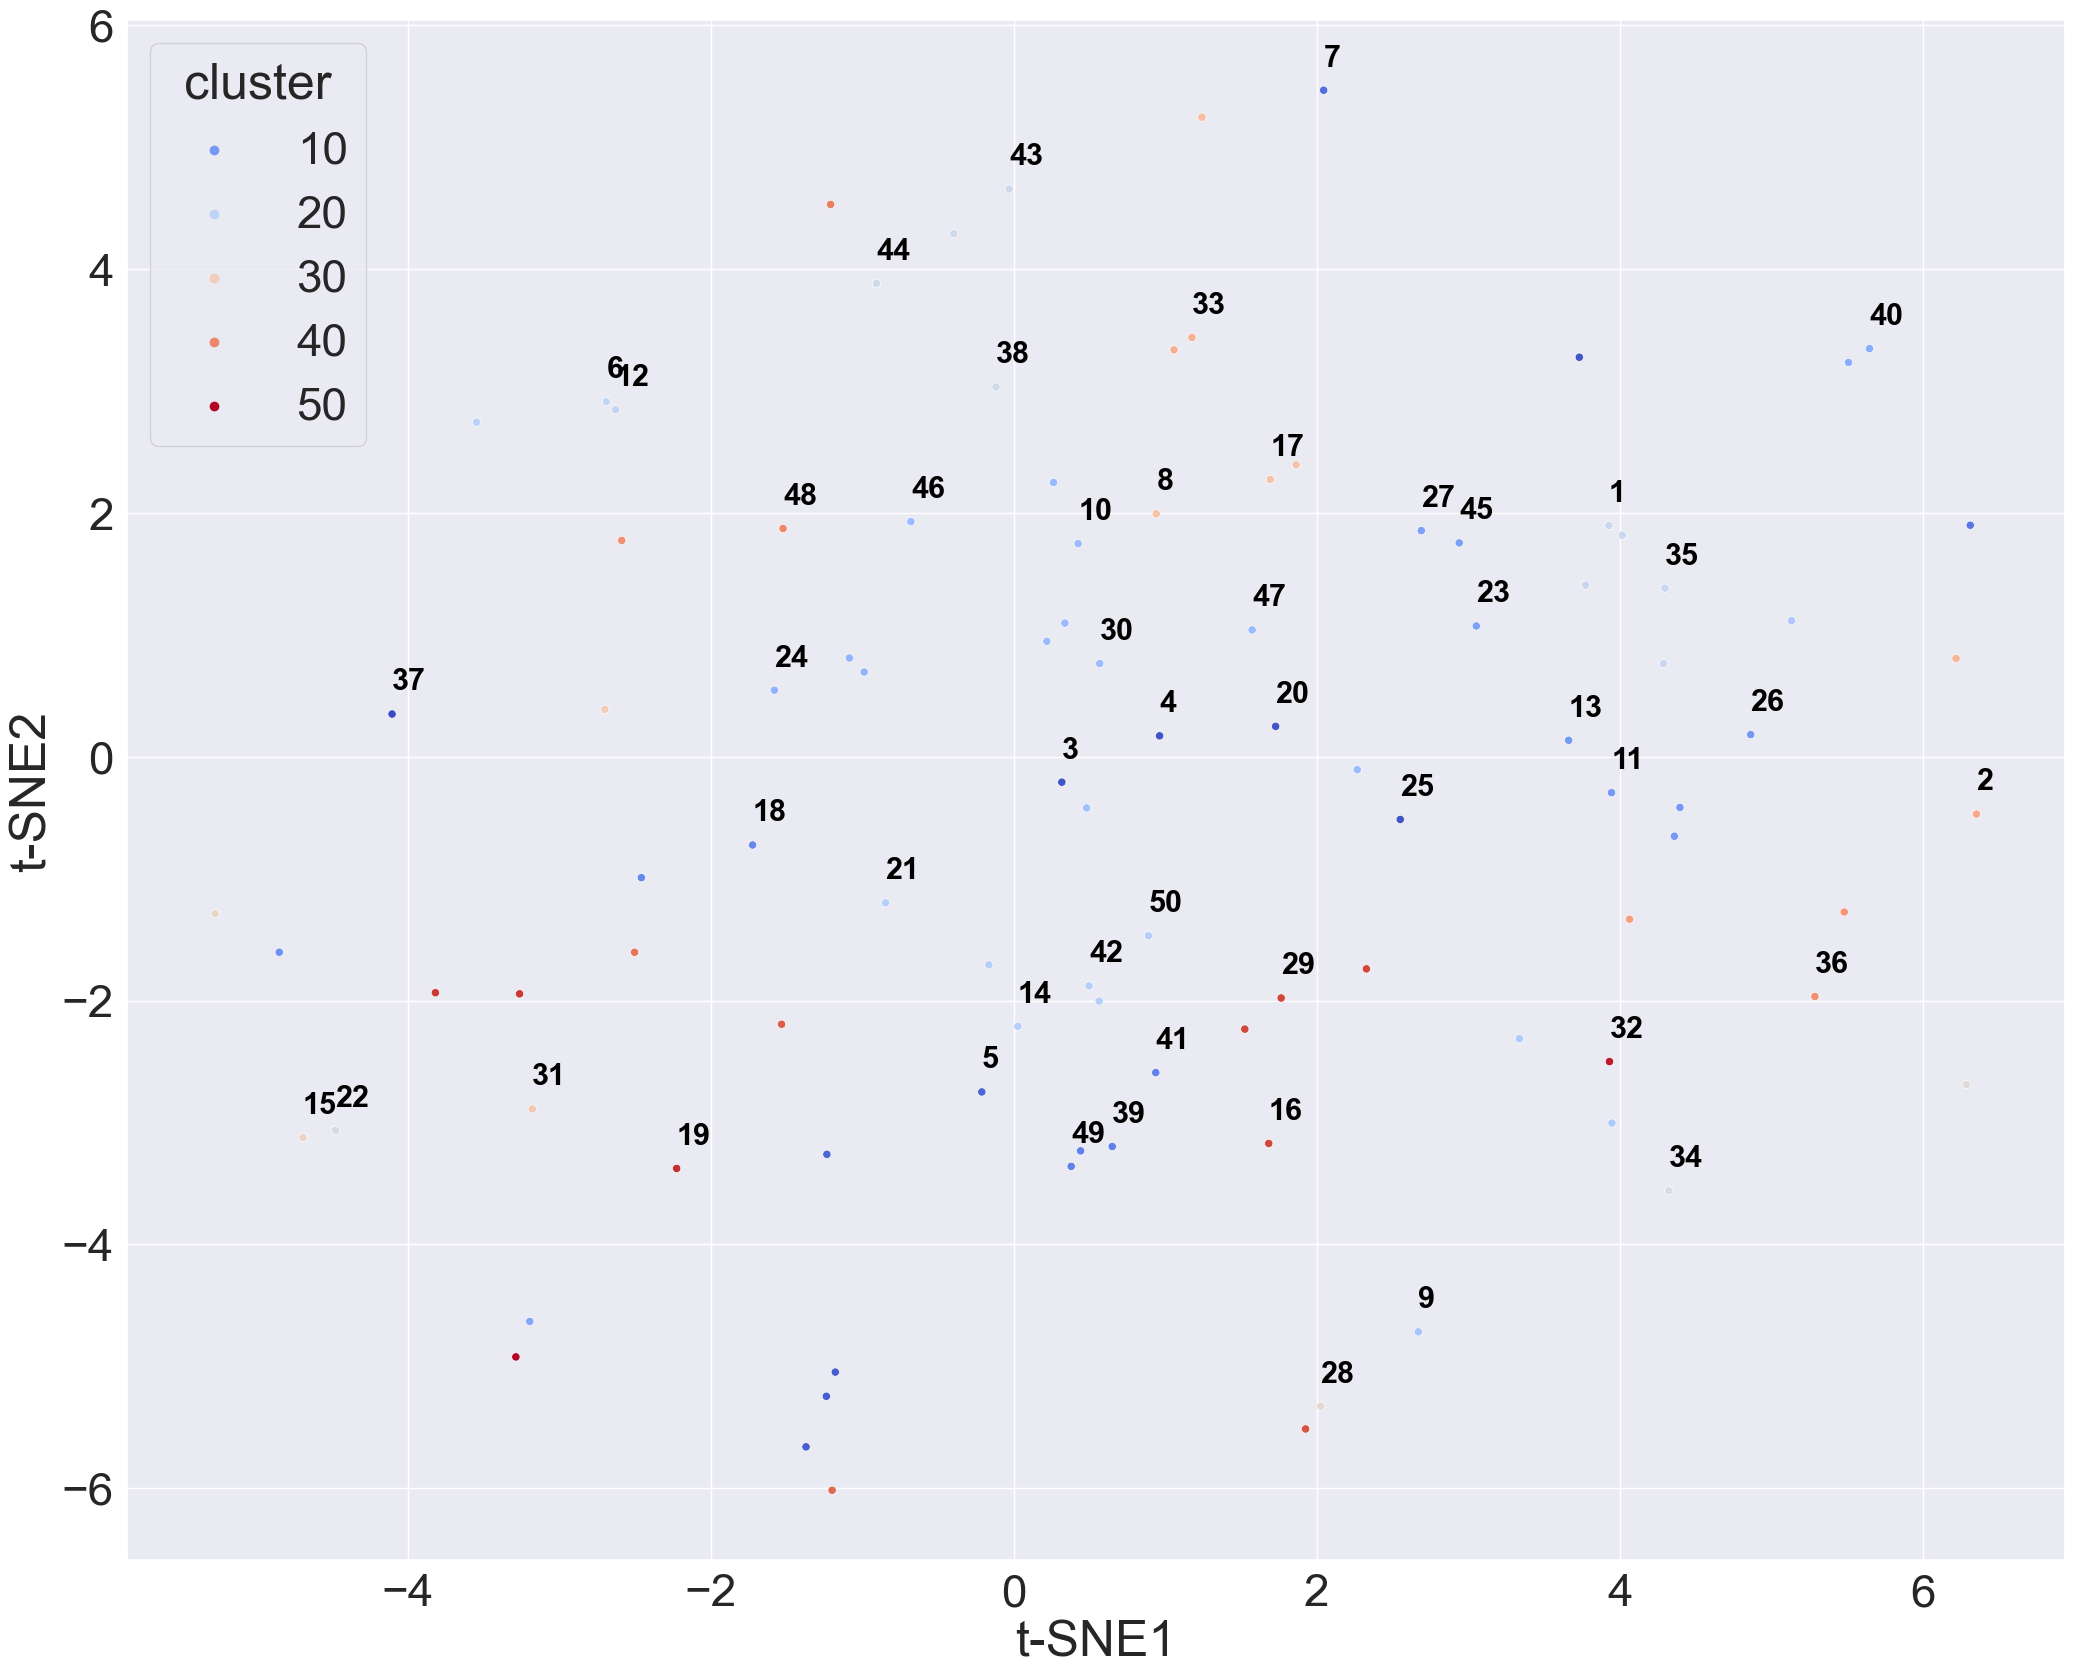

In [24]:
## Visualize Results


# 1. Density Plot
pred = pd.DataFrame(data=loaded_array)

smiles = pd.read_csv('smiles.csv', sep=",")


pred.insert(0, 'SMILES', smiles)

pred.insert(1, "clusters", labels)

s = []
i = 0
index = []

for j in range(0, 50):
  s = pred.loc[pred['clusters'] == j, 'SMILES']
  s = s.to_list()
  for s2 in s:
    i = i + 1
  index.append(i)
  i = 0

###################################

plt.rcParams.update({'font.size': 22})

x = []
for i in range(1, 51):
  x.append(i)

font = {'size': 22}
fig = plt.figure(figsize=(15, 10))
ax = fig.add_axes([0, 0, 1, 1])
langs = x
students = index
ax.bar(langs, students)
ax.set_ylabel('Number of molecules in each cluster\n', fontsize=34)
ax.set_xlabel('\nNumber of clusters ', fontsize=34)
ax.set_xticks([k for k in range(1, 51, 5)])
# ax.set_yticks( fontsize = 20)
ax.set_title('', fontsize=14)

plt.show()

#######################################################################

# 2. t-SNE plot
tsne_comp = TSNE(n_components=2, perplexity=30, random_state=30, n_iter=1000).fit_transform(loaded_array)

tsne_df = pd.DataFrame(data=tsne_comp, columns=['t-SNE1', 't-SNE2'])
tsne_df.head()

tsne_df = pd.concat([tsne_df, pd.DataFrame({'cluster': labels})], axis=1)
tsne_df['cluster'] += 1
tsne_df.head()

text = []
for i in range(1, 51):
  text.append(str(i))
len(text)

plt.figure(figsize=(25, 20))
sns.set(font_scale=3)
z = sns.color_palette("coolwarm", as_cmap=True)
ax = sns.scatterplot(x="t-SNE1", y="t-SNE2", hue="cluster", data=tsne_df, palette=z)
# ax = sns.color_palette("mako", as_cmap=True)
x = tsne_df['t-SNE1']
y = tsne_df['t-SNE2']
for i in range(0, 50):
  plt.annotate(text[i], (x[i], y[i] + .2), size=22, color='black', weight='bold')
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncol = 3 )

plt.show()